# Teste Transferência de Calor

## Teste Incropera 5.124

In [1]:
import numpy
import scipy
from math import pi, fabs, log


## Thermal properties 


In [2]:
# AISI Type 304 Stainless Steel
density = 7900.0 # kg/m3
thermal_conductivity = 17.4 # W/mK
heat_capacity = 526.0 #J/(kg.degK)

initial_temperature = 600.0 # degK

# Data of external conditions
oil_temperature = 300.0 # degK
overral_convection_coefficient = 500.0 #W/(m2.degK)


### Heat Equations 

Fourier Law Equation for direction r and z


**Volume**
* $ V = area_z * \Delta_z $

**Area 'z'**
* $ area_z = \frac{(r_{ex}^2 - r_{in}^2)*\pi}{4.0} $

**Area 'r'**
* $ area_z = \frac{2 \pi* r *\Delta z}{4.0} $

**Conduction equation 'r'**: 
* $ q_r = area_r \kappa*r*\frac{\mathrm d T}{\mathrm d r} $

**Conduction equation 'z'**: 
* $ q_z = area_z \kappa*\frac{\mathrm d T}{\mathrm d z} $

**Boundary condition equation 'r'**:
* $ q_{bc_r} = 2/4 \pi* \Delta z \left( \frac{ T_{oil} - T_p}{ \left( \frac{1}{r_ext h} \right) + \left( \frac{log(\frac{r_{ex}}{r_{in}})}{K} \right) } \right) $

**Boundary condition equation 'z'**: 
* $ q_{bc_z} = area_z \frac{ T_{oil} - T_p}{ \frac{1}{h} + \frac{0.5 \Delta z}{K} } $



In [21]:
def heat_condution_equation_r(T0, T1, radius):
    
    # [J/(s m K)] * m2 * K * 1 / m = J/(s)
    area_r = 2*pi*radius*delta_z/4.0
    return area_r*thermal_conductivity*(T1-T0)/delta_r

def heat_condution_equation_z(T0, T1, area_z):
    
    # [J/(s m K)] * m2 * K * 1 / m = J/(s)
    return area_z*thermal_conductivity*(T1-T0)/delta_z

def boundary_condition_r(Tp, radius, outside_radius):
    
    #  1 /(J/(s m K)) 
    conduction_resistence = log(outside_radius/radius)/(thermal_conductivity)
    #  1 /(J/(s m2 K) * m) =  1 /(J/(s m K) 
    convection_resistence = 1.0/(outside_radius*overral_convection_coefficient)
    
    #  m * K /(1/(J/(s m K))) =  J/s 
    heat_flux = 2/4.0*pi*delta_z*(oil_temperature-Tp)/(conduction_resistence+convection_resistence)
    
    return heat_flux

def boundary_condition_z(Tp, area_z):
    
    #  m /(J/(s m K)) = 1/(J / s K m2)
    conduction_resistence = (delta_z/2)/(thermal_conductivity)
    #  1/(J/ s K m2)
    convection_resistence = 1.0/(overral_convection_coefficient)
    
    #  m2 * K * (1/(J / s K m2)) = (J/s)
    heat_flux = area_z*(oil_temperature-Tp)/(conduction_resistence+convection_resistence)
    
    return heat_flux

## System Data

In [22]:
# height of cylinder
#height = 0.0600 # m
height = 0.030 # m (Symetric condition)

# radius of cylinder
radius = 0.040 # m

number_of_cells_r = 15
number_of_cells_z = 15

delta_r = radius/number_of_cells_r
delta_z = height/number_of_cells_z

time = 600.0 #seconds = 10 min

number_of_timestep = 600
delta_t = time/number_of_timestep # s


## Parcial Differencial Equation

### Cylindrical Coordinates


**Accumulative term **: 
* $  \frac{ \rho  C_p}{ \Delta t} *  (T^n - T^{old}) V $ 

**Conductive Term 'r'**:  
* $ - area_r ( \kappa r \frac{\mathrm d T}{\mathrm d r}|^e - \kappa r \frac{\mathrm d T}{\mathrm d r}|^w )  $

**Conductive Term 'z'**:  
* $ - area_z ( \kappa \frac{\mathrm d T}{\mathrm d r}|^n - \kappa \frac{\mathrm d T}{\mathrm d r}|^s )  $

**Boundary Condition 'r'**:
<blockquote>
<p> $ r \to R $:  $ -(2/4 \pi* \Delta z \left( \frac{ T_{oil} - T_p}{ \left( \frac{1}{r_ext h} \right) + \left( \frac{log(\frac{r_{ex}}{r_{in}})}{K} \right) } \right)|^e - area_r \kappa \frac{\mathrm d T}{\mathrm d r}|^w  ) $

<p> $ r \to 0.0 $:  $ -( area_r \kappa \frac{\mathrm d T}{\mathrm d r}|^e  - 0.0 )  $

</blockquote>

**Boundary Condition 'z'**:

<blockquote>

<p> $ z \to H $ :  $ - area_z ( \frac{ T_{oil} - T_p}{ \frac{1}{h} + \frac{\Delta z*0.5}{K} }|^n - \kappa \frac{\mathrm d T}{\mathrm d r}|^s  )  $

<p> $ z \to 0.0 $:  $ -( - area_r \kappa \frac{\mathrm d T}{\mathrm d r}|^n  - 0.0 )  $

</blockquote>




In [24]:
# Accumulation term
def acc_term(Told, Tnew, area_z):
    # [kg/m3] * J/(kgK) 1/s * K * m * m * m = J/s
    volume = area_z * delta_z 
    return (density * heat_capacity / delta_t) * (Tnew-Told)*volume

# conductive term r
def cond_term_r(Tw, Tp, Te, inside_radius, outside_radius):
    
    # [J/(s m K)] * m * K * 1 / m = J/(m s)
    heat_flux_e = heat_condution_equation_r(Tp, Te, outside_radius)
    heat_flux_w = heat_condution_equation_r(Tw, Tp, inside_radius)
    
    #  J/s
    balance = - (heat_flux_e - heat_flux_w)
    
    return balance

# conductive term z
def cond_term_z(Ts, Tp, Tn, area_z):
    
    # [J/(s m K)] * K * 1 / m = J/(s)
    heat_flux_n = heat_condution_equation_z(Tp, Tn, area_z)
    heat_flux_s = heat_condution_equation_z(Ts, Tp, area_z)
    
    #  J/(s m2) * m2 = J/s
    balance = - (heat_flux_n - heat_flux_s)
    
    return balance

# boundary_condition r
def boundary_condition_term_r(Tw, Tp, Te, radius, outside_radius, inside_radius):
    
    if (Te == None):
        #  m * K /(1/(J/(s m K))) =  J/s 
        heat_flux_e = boundary_condition_r(Tp, radius, outside_radius)
    else:
        # [J/(s m K)] * m * K * 1 / m * m = J/(s)
        heat_flux_e = heat_condution_equation_r(Tp, Te, outside_radius)
    
    if (Tw == None):
        heat_flux_w = 0.0 # constant flux
    else:
        heat_flux_w = heat_condution_equation_r(Tw, Tp, inside_radius)
    
    balance = - (heat_flux_e - heat_flux_w)
    
    return balance

# boundary_condition z
def boundary_condition_term_z(Ts, Tp, Tn, area_z):
    
    if (Tn == None):
        #  m2 * K * (1/(J / s K m2)) = (J/s)
        heat_flux_n = boundary_condition_z(Tp, area_z)
    else:
        # [J/(s m K)] * K * 1 / m * m2 = J/(s)
        heat_flux_n = heat_condution_equation_z(Tp, Tn,area_z)
    
    if (Ts == None):
        heat_flux_s = 0.0#*boundary_condition_z(Tp, inside_radius, outside_radius)/(delta_r*radius)
    else:
        heat_flux_s = heat_condution_equation_z(Ts, Tp,area_z)
    
    balance = -(heat_flux_n - heat_flux_s)
    
    return balance


def residual_edp(Told, Ts, Tw, Tp, Te, Tn, radius, inside_radius, outside_radius):
    

    area_z = (outside_radius**2 - inside_radius**2)*pi/4.0
    
    if (Ts == None or Tn == None):
        conduction_z = boundary_condition_term_z(Ts, Tp, Tn, area_z)
    else:
        conduction_z = cond_term_z(Ts, Tp, Tn, area_z)    
    
    if (Tw == None or Te == None):
        conduction_r = boundary_condition_term_r(Tw, Tp, Te, radius, outside_radius, inside_radius)
    else:
        conduction_r = cond_term_r(Tw, Tp, Te, inside_radius, outside_radius) 
    
    residual = acc_term(Told, Tp, area_z) + conduction_z + conduction_r
    
    return residual

In [25]:
from scipy.optimize.nonlin import newton_krylov
import copy

# Initial temperature T(z,r,0) = initial temperature
Told = numpy.ones((number_of_cells_z, number_of_cells_r))*initial_temperature

T = copy.deepcopy(Told)
T3min = copy.deepcopy(T)


T_center = numpy.ones(number_of_timestep+1)*initial_temperature
T_center_of_lateral_surface = copy.deepcopy(T_center)
T_center_of_top_surface = copy.deepcopy(T_center)
times = numpy.zeros(number_of_timestep+1)

residual = numpy.ones((number_of_cells_z, number_of_cells_r))*1e5

delta_radius_vector = numpy.ones(number_of_cells_r)*delta_r
radius_vector = numpy.cumsum(delta_radius_vector)
radius_vector = numpy.insert(radius_vector, 0, 0.0, axis=0)

n = 0
def solve_one_timestep(T):
    
    for j in xrange(number_of_cells_z):
        for i in xrange(number_of_cells_r):
            
            Told_p = Told[j,i]
            
            inside_radius= radius_vector[i]
            outside_radius = radius_vector[i+1]
            radius = (inside_radius + outside_radius)/2
            
            Tp = T[j,i]
            
            if (i==0):
                Tw = None
            else:
                Tw = T[j,i-1]
            
            if (i==number_of_cells_r - 1):                
                Te = None
            else:
                Te = T[j,i+1]
                
            if (j==0):
                Ts = None
            else:
                Ts = T[j-1,i]
                
            if (j==number_of_cells_z - 1):
                Tn = None
            else:
                Tn = T[j+1,i]
            
            residual[j,i]  =  residual_edp(Told_p, Ts, Tw, Tp, Te, Tn, radius, inside_radius, outside_radius)
            
            T_center[n+1] = T[0,0]
            T_center_of_lateral_surface[n+1] = T[0,number_of_cells_r-1]
            T_center_of_top_surface[n+1] = T[number_of_cells_z - 1,0]   
            times[n+1] = (n+1)*delta_t
    
    return residual

residual = solve_one_timestep(T)

timesteps = number_of_timestep
time = timesteps*delta_t
for n in xrange(timesteps):
    
    sol = newton_krylov(solve_one_timestep, T, method='lgmres')    
    Told = sol
    if (n == 180):
        T3min = sol



## (a) Temperature (Center, Center of Lateral Surface, Center of Top surface) at 3min


In [26]:
# temperature T(0,0, 3 min)
print "--"*20
print "T(0, 0,3 min) = %6.3f  degK \n" %(T_center[180])

print "T(0, R,3 min) = %6.3f  degK \n" %(T_center_of_lateral_surface[180])

print "T(L, 0,3 min) = %6.3f  degK \n" %(T_center_of_top_surface[180])
print "--"*20

----------------------------------------
T(0, 0,3 min) = 403.275  degK 

T(0, R,3 min) = 365.188  degK 

T(L, 0,3 min) = 372.952  degK 

----------------------------------------


## (b) Temperature (Center, Center of Lateral Surface, Center of Top surface) at (0min to 10min)


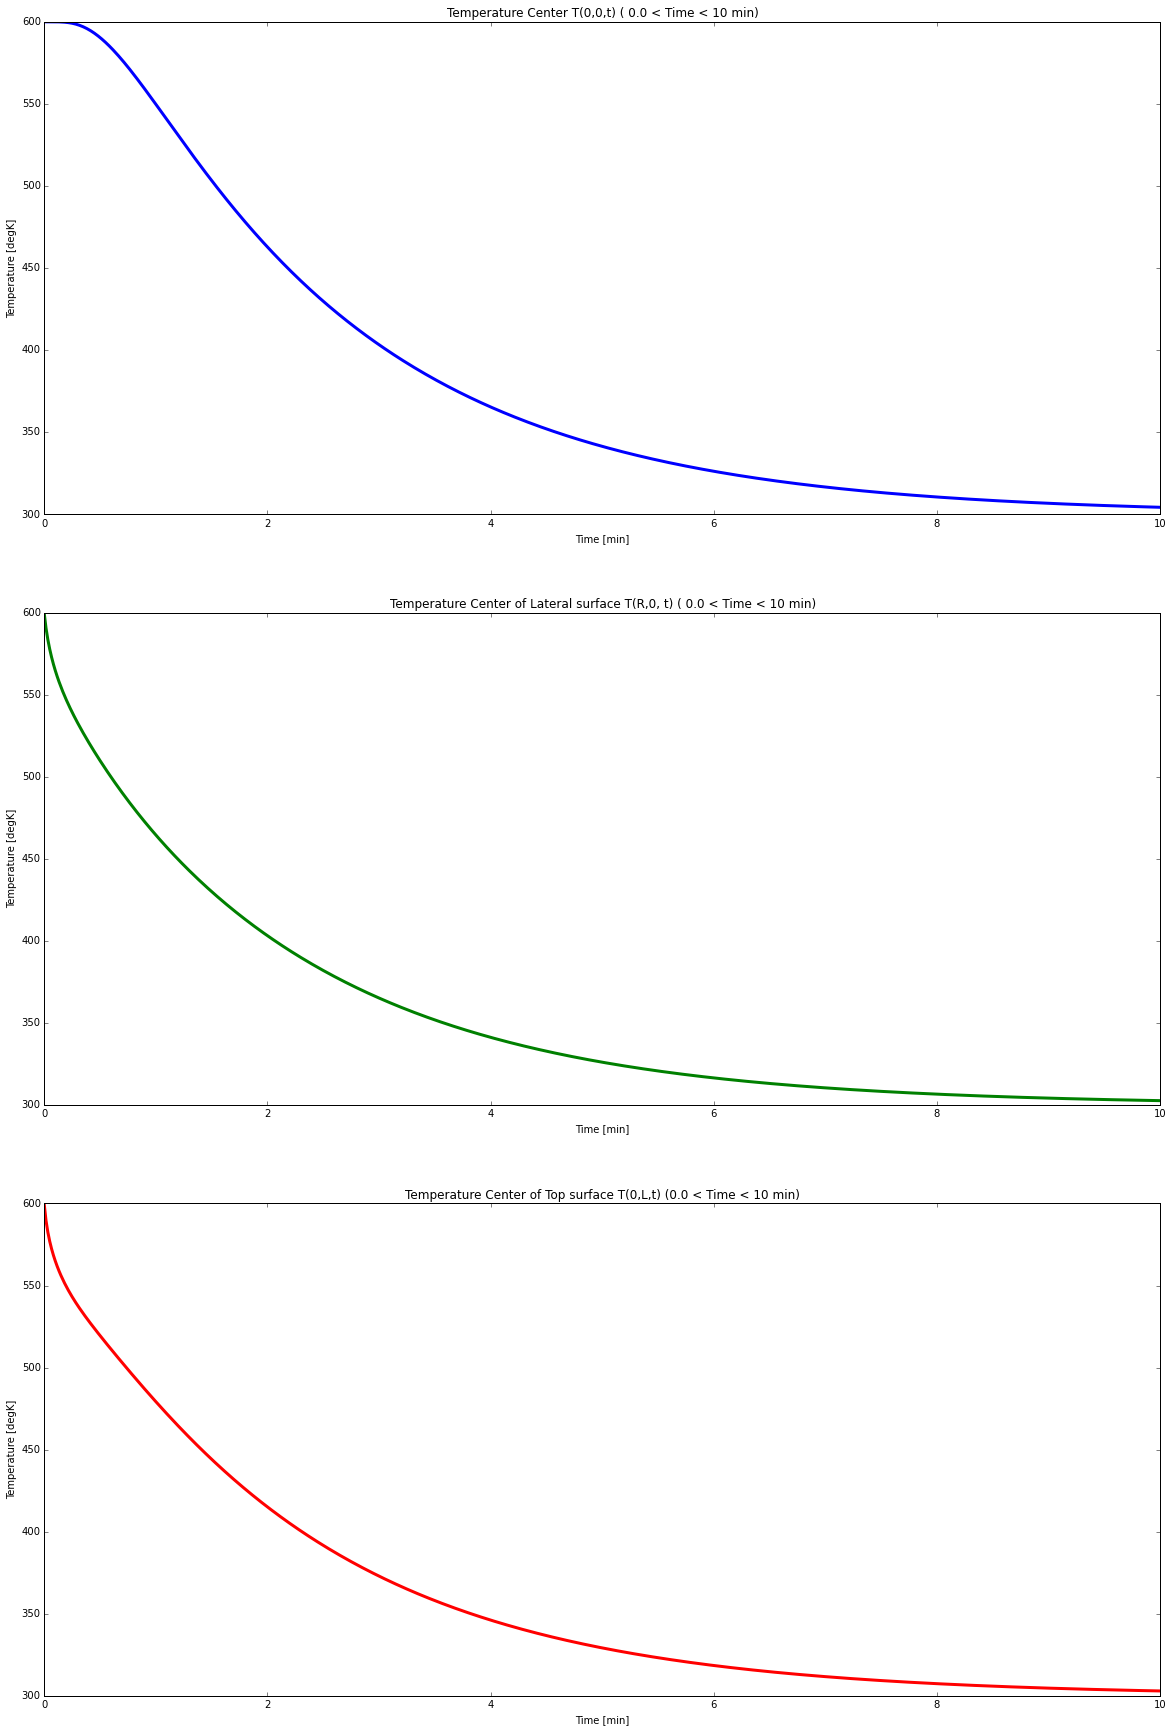

In [27]:
from matplotlib.pyplot import plot, show,legend,xlabel, ylabel, title, figure

from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt

# imports specific to the plots in this example
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data


%matplotlib inline
# Twice as wide as it is tall.
fig = plt.figure(figsize=(20,30))

ax = fig.add_subplot(3, 1, 1)
ax.plot(times/60, T_center, '-b',label='center', lw=3)
ax.set_title('Temperature Center T(0,0,t) ( 0.0 < Time < 10 min)')
ax.set_xlabel('Time [min]')
ax.set_ylabel('Temperature [degK]')
#ax.legend(loc=0)

ax1 = fig.add_subplot(3, 1, 2)
ax1.plot(times/60, T_center_of_lateral_surface, '-g', lw=3)
ax1.set_title('Temperature Center of Lateral surface T(R,0, t) ( 0.0 < Time < 10 min)')
ax1.set_xlabel('Time [min]')
ax1.set_ylabel('Temperature [degK]')
#ax1.legend(loc=0)

ax2 = fig.add_subplot(3, 1, 3)
ax2.plot(times/60, T_center_of_top_surface,'-r', lw=3)
ax2.set_title('Temperature Center of Top surface T(0,L,t) (0.0 < Time < 10 min)')
ax2.set_xlabel('Time [min]')
ax2.set_ylabel('Temperature [degK]')

plt.show()


# (c) Temperature Profile at 3min

In [28]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt

delta_height_vector = numpy.ones(number_of_cells_z)*delta_z
height_vector = numpy.cumsum(delta_height_vector)
height_vector = numpy.insert(height_vector, 0, 0.0, axis=0)

# imports specific to the plots in this example
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data

def plot3d_generate(T):
    # Twice as wide as it is tall.
    fig = plt.figure(figsize=(20,10))

    #---- First subplot
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    X = height_vector[:-1]
    Y = radius_vector[:-1]
    X, Y = np.meshgrid(X, Y)

    ax.set_xlabel('Height (m)')
    ax.set_ylabel('Radius (m)')
    ax.set_zlabel('Temperature (degK)')
    ax.set_title(' Temperature profile at 3min')
    ax.view_init(elev=30., azim=30.0)

    Z = T

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=10)


    plt.show()

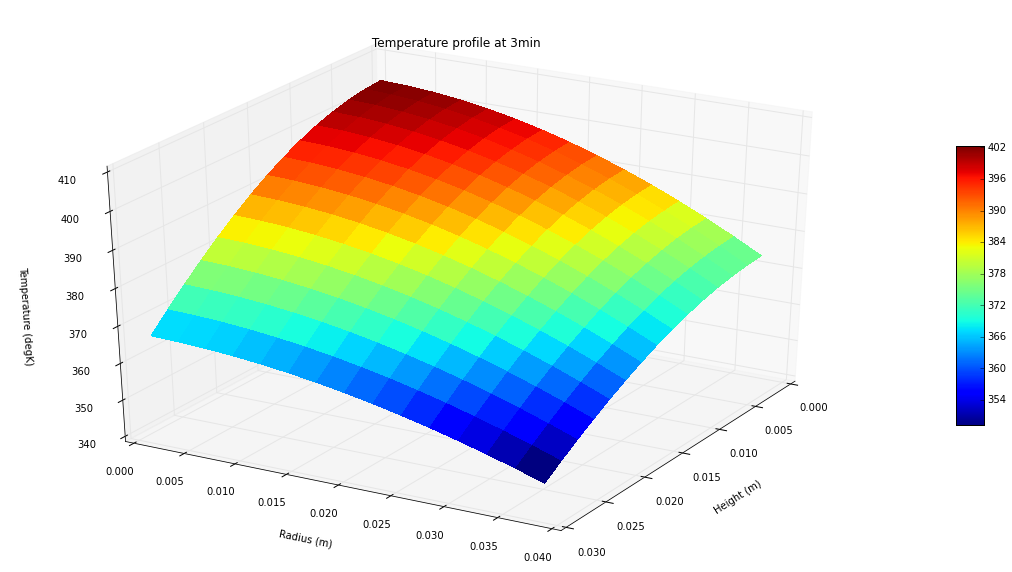

In [29]:
plot3d_generate(T3min)


## (c2) Temperature Profile at 10min

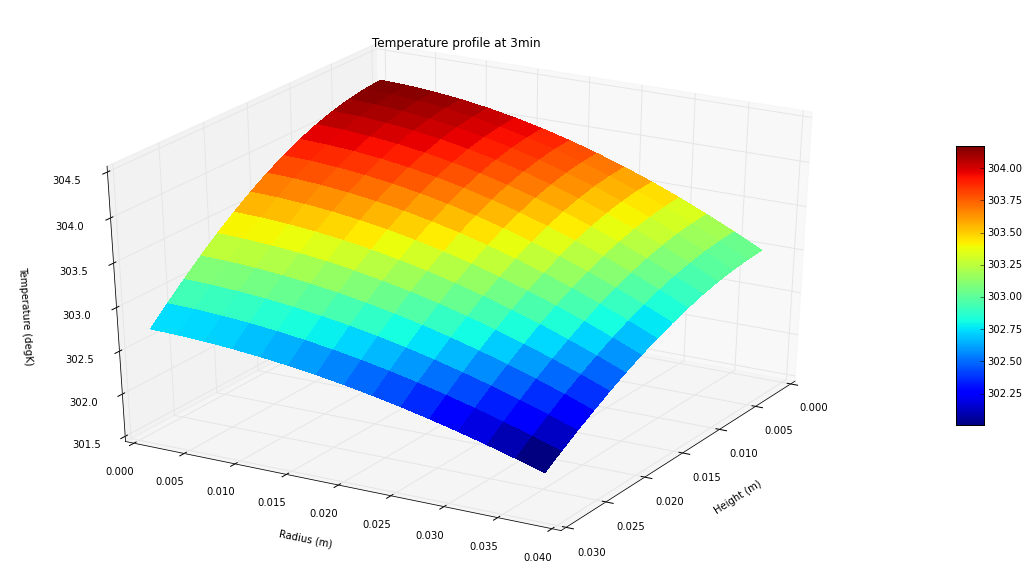

In [30]:
plot3d_generate(Told)